In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline


In [16]:
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


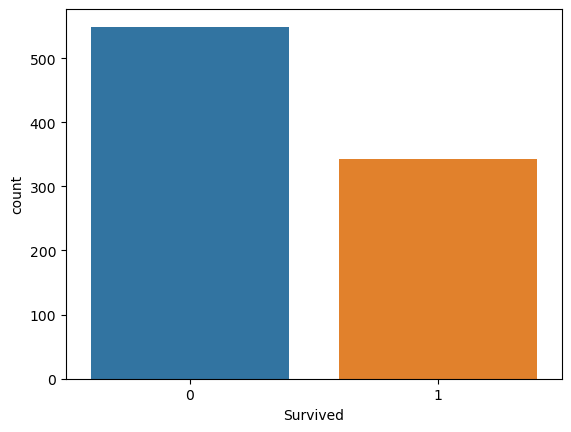

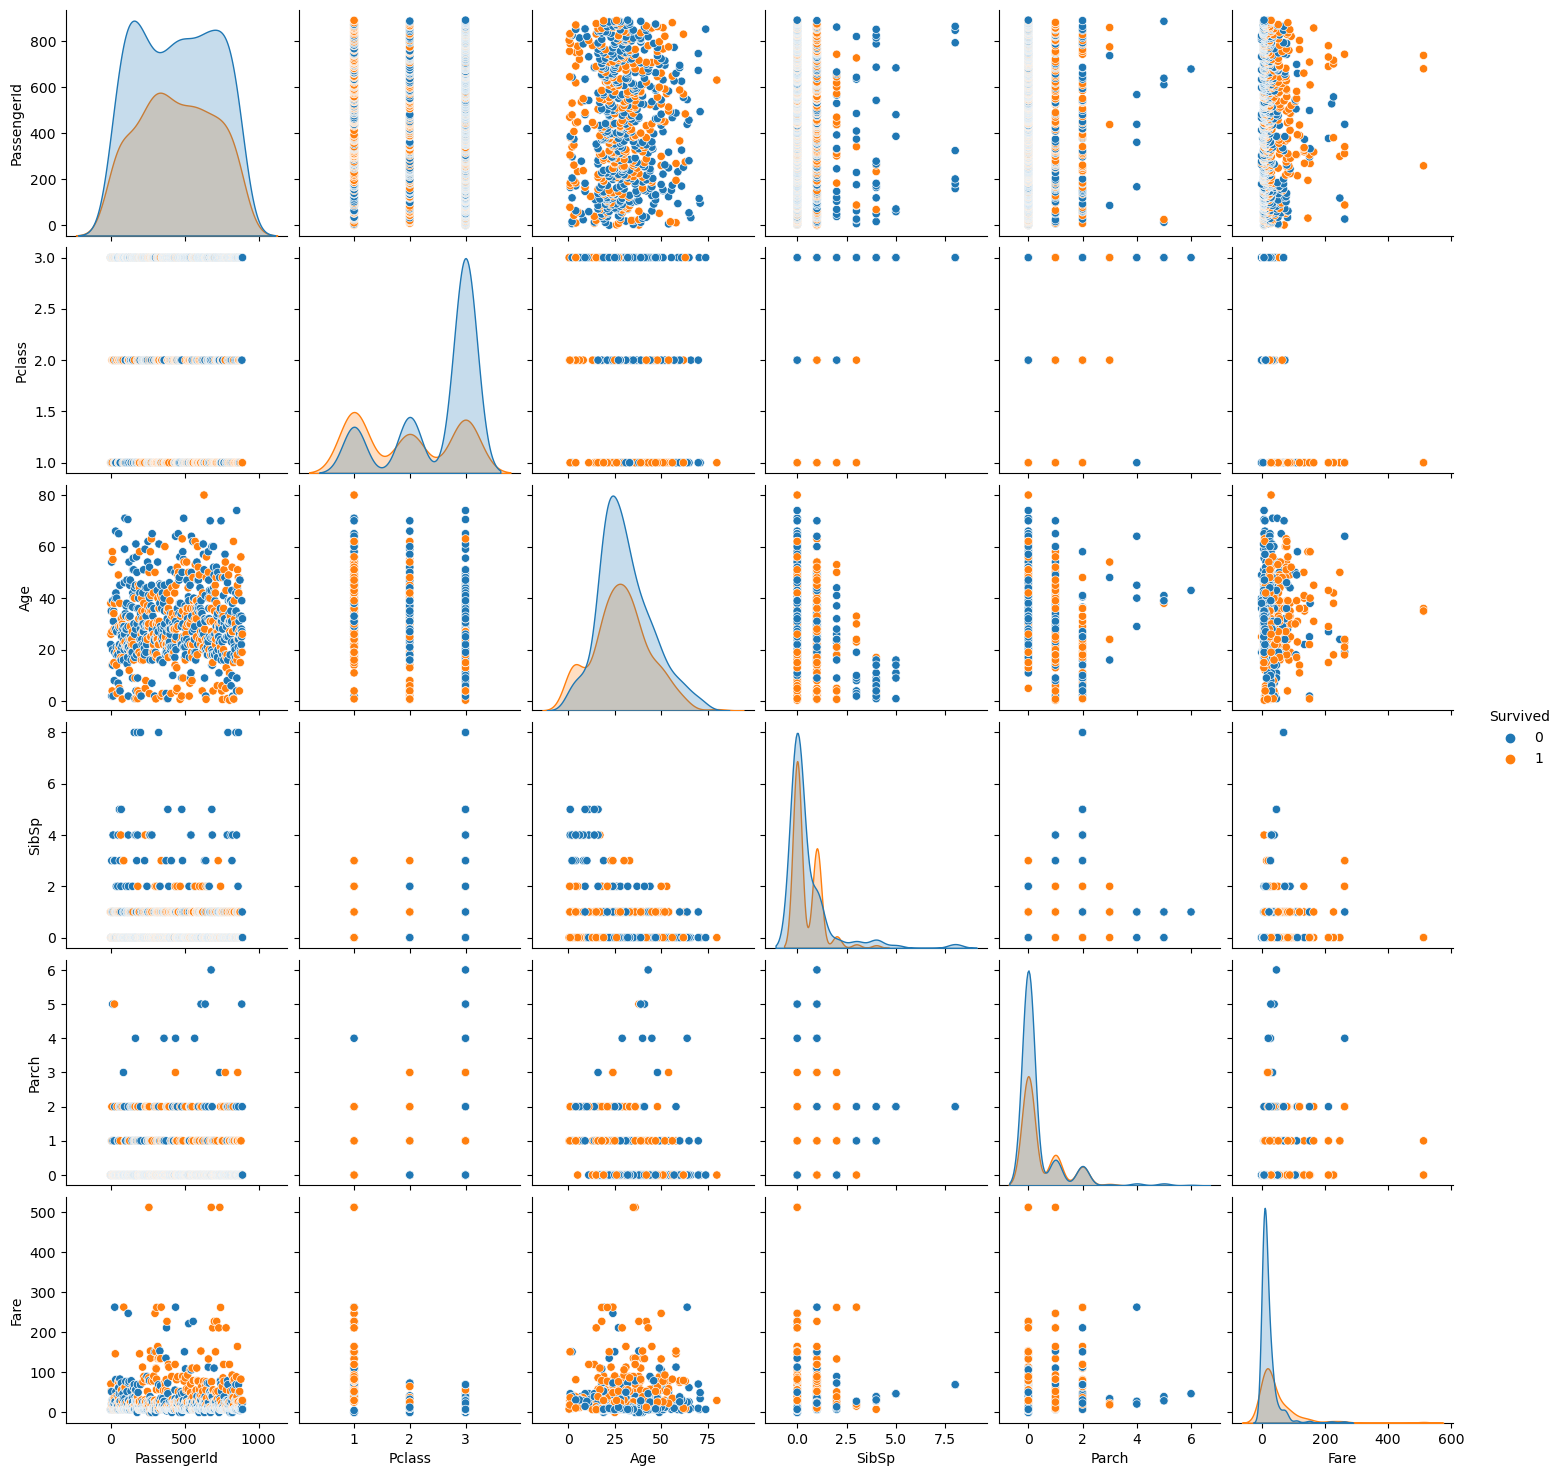

In [17]:
# Print the first few rows of the dataframe
print(df.head())

# Display the distribution of 'Survived'
sns.countplot(x='Survived', data=df)
plt.show()

# More detailed exploration
sns.pairplot(df, hue='Survived')
plt.show()


In [18]:
from sklearn.datasets import load_iris

In [19]:
data = load_iris()

In [20]:
iris = pd.DataFrame(np.c_[data['data'], data['target']])

In [21]:
iris.rename(columns={0:'sepal length', 1:'sepal width', 2:'pedal length', 3:'pedal width', 4:'target'}, inplace=True)

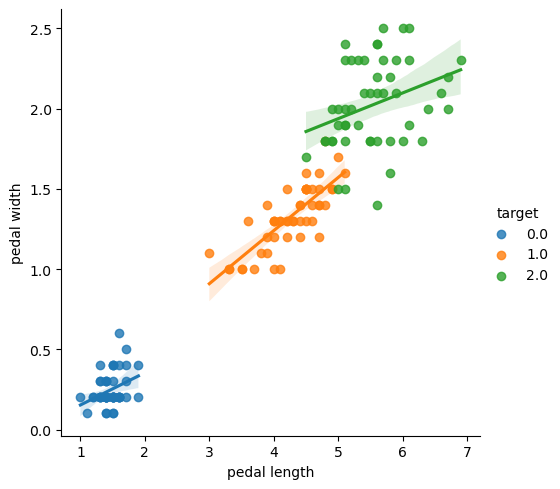

In [22]:
sns.lmplot(x='pedal length', y='pedal width', hue='target', data=iris)

In [23]:
# drop useless columns
df.drop(['Ticket', 'Cabin'], axis=1, inplace=True)

In [24]:
# find missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


In [25]:
# clean missing data
df['Age'] = df['Age'].fillna(df.groupby('Sex')['Age'].transform('mean'))
df['Embarked'] = df['Embarked'].fillna('S')

In [26]:
cat_columns = ['Pclass','Sex','Embarked']
num_columns = ['Age','SibSp','Parch','Fare']
target = 'Survived'

In [27]:
# build pipeline
cat_transformer = OneHotEncoder(handle_unknown='ignore')
num_transformer = StandardScaler()
preprocessor = ColumnTransformer(transformers = [('cat',cat_transformer, cat_columns),
                                                 ('num', num_transformer, num_columns)])

In [28]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(df[cat_columns + num_columns], df[target], test_size=0.2, random_state=42)



In [29]:
x_train_transformed = preprocessor.fit_transform(X_train)
x_test_transformed = preprocessor.fit_transform(X_test)

In [30]:
x_train_transformed.shape

(712, 12)

In [31]:
x_test_transformed.shape

(179, 12)

In [32]:
encoded_columns = list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_columns))
all_feat = num_columns + encoded_columns

X_train_transformed = pd.DataFrame(x_train_transformed, columns=all_feat)
X_test_transformed = pd.DataFrame(x_test_transformed, columns=all_feat)


In [43]:
avg_accuracy = []

for i in range(1,10):
    accuracies = []
    for i in range(1,100):
        knn = KNeighborsClassifier(n_neighbors= i)
        knn.fit(X_train_transformed, y_train)
        y_pred = knn.predict(X_test_transformed)
        #print(f1_score(y_pred, y_test))
        #print(accuracy_score(y_pred, y_test))
        accuracies.append(accuracy_score(y_pred, y_test))
    avg_accuracy.append(np.mean(accuracies))

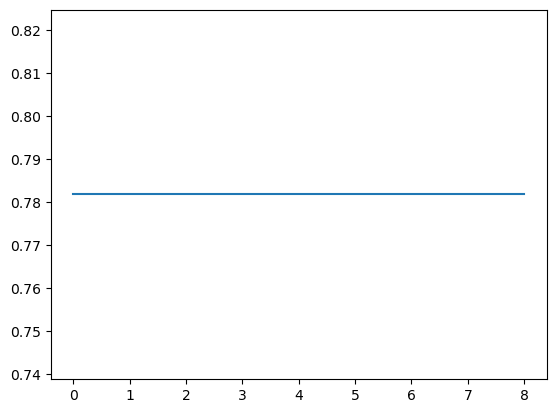

In [44]:
plt.plot(avg_accuracy)

In [45]:
# Hyperparameter tuning
# select parameters
params_nb = {'var_smoothing': np.logspace(0,-9, num=100)}
params_knn = {'n_neighbors': list(range(1,31)), 'weights': ['uniform', 'distance']}

# Define the models
nb = GaussianNB()
knn = KNeighborsClassifier()

# Define GridSearchCV
gridsearch_nb = GridSearchCV(nb, params_nb, cv=5)
randomsearch_knn = RandomizedSearchCV(knn, params_knn, cv=5)

# Fit models
gridsearch_nb.fit(X_train_transformed, y_train)
randomsearch_knn.fit(X_train_transformed, y_train)

# Get the best parameters
print("Best parameters for Naive Bayes: ", gridsearch_nb.best_params_)
print("Best parameters for KNN: ", randomsearch_knn.best_params_)

Best parameters for Naive Bayes:  {'var_smoothing': 0.1}
Best parameters for KNN:  {'weights': 'uniform', 'n_neighbors': 23}


In [46]:
# Apply the best parameters
nb_best = GaussianNB(**gridsearch_nb.best_params_)
knn_best = KNeighborsClassifier(**randomsearch_knn.best_params_)

# Perform cross-validation
cv_scores_nb = cross_val_score(nb_best, X_train_transformed, y_train, cv=5, scoring='roc_auc')
cv_scores_knn = cross_val_score(knn_best, X_train_transformed, y_train, cv=5, scoring='roc_auc')

print("Cross-validation scores for Naive Bayes: ", cv_scores_nb)
print("Cross-validation scores for KNN: ", cv_scores_knn)

# Fit the models with the best parameters
nb_best.fit(X_train_transformed, y_train)
knn_best.fit(X_train_transformed, y_train)

# Evaluate on the test set
y_pred_nb = nb_best.predict(X_test_transformed)
y_pred_knn = knn_best.predict(X_test_transformed)

print("Test accuracy for Naive Bayes: ", accuracy_score(y_test, y_pred_nb))
print("Test accuracy for KNN: ", accuracy_score(y_test, y_pred_knn))

Cross-validation scores for Naive Bayes:  [0.8585102  0.82532251 0.83994064 0.7758109  0.85690236]
Cross-validation scores for KNN:  [0.87005826 0.84092801 0.84640661 0.83241467 0.86353114]
Test accuracy for Naive Bayes:  0.770949720670391
Test accuracy for KNN:  0.8100558659217877


In [47]:
# Compute metrics
print("Naive Bayes Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_nb))
print("Accuracy: ", accuracy_score(y_test, y_pred_nb))
print("Precision: ", precision_score(y_test, y_pred_nb))
print("Recall: ", recall_score(y_test, y_pred_nb))
print("F1 Score: ", f1_score(y_test, y_pred_nb))

print("\nK-Nearest Neighbors Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_knn))
print("Accuracy: ", accuracy_score(y_test, y_pred_knn))
print("Precision: ", precision_score(y_test, y_pred_knn))
print("Recall: ", recall_score(y_test, y_pred_knn))
print("F1 Score: ", f1_score(y_test, y_pred_knn))

Naive Bayes Metrics: 
Confusion Matrix:  [[87 18]
 [23 51]]
Accuracy:  0.770949720670391
Precision:  0.7391304347826086
Recall:  0.6891891891891891
F1 Score:  0.7132867132867132

K-Nearest Neighbors Metrics: 
Confusion Matrix:  [[92 13]
 [21 53]]
Accuracy:  0.8100558659217877
Precision:  0.803030303030303
Recall:  0.7162162162162162
F1 Score:  0.7571428571428571
